<a href="https://www.kaggle.com/code/averma111/timeseries-split?scriptVersionId=136900081" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
%reload_ext autoreload

from time import time

import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.5f}'.format
from IPython.display import display

# Sklearn tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Plotting
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

# Visualizations
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/playground-series-s3e19/sample_submission.csv
/kaggle/input/playground-series-s3e19/train.csv
/kaggle/input/playground-series-s3e19/test.csv


In [13]:
class DataAcquisition:
    
    def __init__(self):
        self.X_train=None
        self.X_val=None
        self.y_train=None
        self.y_val=None
    
    def prepare_data(self):
        path = '/kaggle/input/playground-series-s3e19/train.csv'
        df = pd.read_csv(
            path, 
            sep=',', 
            parse_dates=['date'], 
            infer_datetime_format=True, 
            low_memory=False
        )
        
        X = df.copy()
        return X
    
    def prepare_data_test(self):
        path = '/kaggle/input/playground-series-s3e19/test.csv'
        df = pd.read_csv(
            path, 
            sep=',', 
            parse_dates=['date'], 
            infer_datetime_format=True, 
            low_memory=False
        )
        
        X = df.copy()
        return X
    
    
    def new_features(self,df):
        df['month'] = df['date'].dt.month
        df['day'] = df['date'].dt.day
        df['year'] = df['date'].dt.year
        df['dayofweek'] = df['date'].dt.dayofweek
        df['quarter'] = df['date'].dt.quarter
        df['dayofmonth'] = df['date'].dt.day
        df['weekofyear'] = df['date'].dt.weekofyear
        #df['month_sin'] = np.sin(2*np.pi*df.month/12)
        #df['month_cos'] = np.cos(2*np.pi*df.month/12)
        #df['day_sin'] = np.sin(2*np.pi*df.day/24)
        #df['day_cos'] = np.cos(2*np.pi*df.day/24)
        return df
    
    
    
    def preprocessing(self,df):
        X = self.new_features(df)
        #X['store'] =  LabelEncoder().fit_transform(X['store'])
        #X['product'] =  LabelEncoder().fit_transform(X['product'])
        #X['country'] =  LabelEncoder().fit_transform(X['country'])
        X = X.loc[:, X.columns!='id']
        y = X['num_sold']
        X.drop(columns=['date','num_sold'],axis=1,inplace=True)
        return X,y
        
    def preprocessing_test(self,df):
        X = self.new_features(df)
        X['store'] =  LabelEncoder().fit_transform(X['store'])
        X['product'] =  LabelEncoder().fit_transform(X['product'])
        X['country'] =  LabelEncoder().fit_transform(X['country'])
        X = X.loc[:, X.columns!='id']
        X.drop(columns=['date'],axis=1,inplace=True)
        self.X_test = X
        return  self.X_test
    
        
acq = DataAcquisition()

train_df = acq.prepare_data()
test_df = acq.prepare_data_test()

In [14]:
train_df.head()

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49


In [22]:
train_df['product'].value_counts()

Using LLMs to Improve Your Coding                 27390
Using LLMs to Train More LLMs                     27390
Using LLMs to Win Friends and Influence People    27390
Using LLMs to Win More Kaggle Competitions        27390
Using LLMs to Write Better                        27390
Name: product, dtype: int64

In [15]:
train_df.head()
X,y=acq.preprocessing(train_df)

In [16]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48,
    max_train_size=10000,
    test_size=1000,
)

In [17]:
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]

In [24]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder

categorical_columns = [
    "country",
    "store",
    "product",
]
categories = [
    ["Argentina", "Canada", "Estonia","Japan","Spain"],
    ["Kaggle Learn", "Kaggle Store", "Kagglazon"],
    ["Using LLMs to Improve Your Coding", "Using LLMs to Train More LLMs",
    "Using LLMs to Win Friends and Influence People","Using LLMs to Win More Kaggle Competitions",
    "Using LLMs to Write Better"]
]
ordinal_encoder = OrdinalEncoder(categories=categories)


gbrt_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", ordinal_encoder, categorical_columns),
        ],
        remainder="passthrough",
        verbose_feature_names_out=False,
    ),
    HistGradientBoostingRegressor(
        categorical_features=categorical_columns,
        random_state=42,
    ),
).set_output(transform="pandas")

In [36]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

In [37]:
evaluate(gbrt_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     15.528 +/- 10.360
Root Mean Squared Error: 31.510 +/- 24.775


In [39]:
import numpy as np

from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
alphas = np.logspace(-6, 6, 25)
naive_linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),
        ],
        remainder=MinMaxScaler(),
    ),
    RidgeCV(alphas=alphas),
)

In [46]:
evaluate(naive_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     75.214 +/- 6.815
Root Mean Squared Error: 107.795 +/- 15.485


In [50]:
naive_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
naive_linear_predictions = naive_linear_pipeline.predict(X.iloc[test_0])

one_hot_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
one_hot_linear_predictions = one_hot_linear_pipeline.predict(X.iloc[test_0])

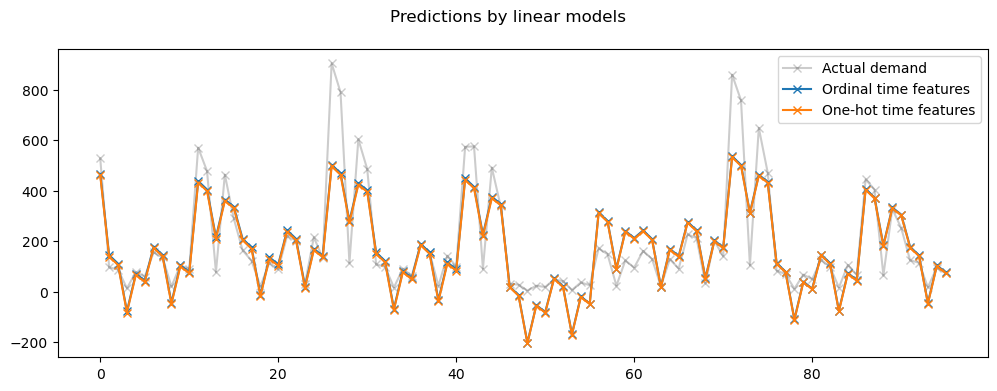

In [51]:
last_hours = slice(-96, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by linear models")
ax.plot(
    y.iloc[test_0].values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(
    naive_linear_predictions[last_hours], 
    "x-", 
    label="Ordinal time features"
)

ax.plot(
    one_hot_linear_predictions[last_hours],
    "x-",
    label="One-hot time features",
)
_ = ax.legend()